<a href="https://colab.research.google.com/github/ian-byrne/MADSmilestone2/blob/main/Supervised_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Learning: Clock Drawing Image Classification with Convolutional Neural Networks
### Stacey Beck and Ian Byrne

- Split data into sets of Training (x = image arrays ; y = labels), Test (~10% image arrays), and Validation (~10% of the Training). 
- Build CNN using Pytorch for Training and Test:
  - Specify CUDA
  - 2D convolution, Normalization (for faster training), Non-linear Activation Function (ex. RELU), Max Pooling (downsampling to reduce learned parameters).
  - Define Layers 
  - Build Forward and backward pass
  - Define optimizer (due to many - deep - nodes) ex) ADAM
  - Calculate Loss (BCE)
  - Calculate Accuracy, Precision, Recall (Confusion Matrix)
  - Plot ROC and print Confusion Matrix



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Clone the entire repo.
!git clone -l -s https://github.com/ian-byrne/MADSmilestone2.git

# Change directory into cloned repo
%cd MADSmilestone2

# List repo contents
#!ls

Cloning into 'MADSmilestone2'...
remote: Enumerating objects: 449, done.
remote: Counting objects: 100% (449/449), done.
remote: Compressing objects: 100% (372/372), done.
remote: Total 449 (delta 252), reused 170 (delta 71), pack-reused 0
Receiving objects: 100% (449/449), 3.24 MiB | 5.64 MiB/s, done.
Resolving deltas: 100% (252/252), done.
/content/MADSmilestone2


In [ ]:
# General Libraries
import pandas as pd
import numpy as np

# Custom Libraries
Loading.load_data as ld
import Images

# Pytroch Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

# To Evaluate model
from tqdm import tqdm
import torchmetrics
from torchmetrics import ConfusionMatrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# To visualize model
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from skimage.io import imread

# To split the data
from sklearn.model_selection import train_test_split

!pip install torchmetrics

In [ ]:
#!rm -rf /content/MADSmilestone2

# Build CNN Model using Pytorch


### Building and Training
Architecture choices influenced from: 

https://www.analyticsvidhya.com/blog/2018/12/guide-convolutional-neural-network-cnn/

https://medium.datadriveninvestor.com/five-powerful-cnn-architectures-b939c9ddd57b

https://towardsdatascience.com/how-does-sparse-convolution-work-3257a0a8fd1

In [ ]:
# Define some of the hyperparameters and training variables
#num_epochs = 20
batch_size = 8
learning_rate = .001
kernel_size = 3
stride = 1
padding = 1 #2*floor(3/2)
#activation function

In [ ]:
# Load numpy array files, add dimension of 1 for gray scale, and zip images and labels 
# get zipped im label and separate label tensors
training_data, y_train_tensor = ld.load_np_files("train_images.npy", "train_labels.npy")
validation_data, y_val_tensor = ld.load_np_files("val_images.npy", "val_labels.npy")
test_data, y_test_tensor = ld.load_np_files("test_images.npy", "test_labels.npy")


(41089, 1, 207, 160)
(5136, 1, 207, 160)
(4587, 1, 207, 160)


In [ ]:
# Get image data and label tensors
train_loader = torch.utils.data.DataLoader(training_data, batch_size = batch_size, shuffle = False) 
validate_loader = torch.utils.data.DataLoader(validation_data, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)


#Labels 
classes = (0, 1, 2)

torch.LongTensor
torch.Size([8, 1, 207, 160])


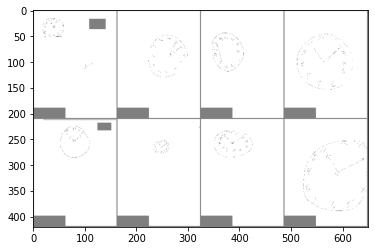

Labels:
    0     2     2     2     2     1     2     2


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
#print(images.size())
print(images.type())
#images = images.unsqueeze(1)
print(images.size())
# show images
imshow(torchvision.utils.make_grid(images, nrow = 4))
# print labels
print('Labels:')
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

#Printing as RGB, just using basic pytorch dataloader likely converting to rbg

(16, 1, 3, 3)

(16,)

(16,)

(16,)

(32, 16, 3, 3)

(32,)

(32,)

(32,)

(120, 65280)

(120,)

(30, 120)

(30,)

(3, 30)

(3,)

[1 1000] loss 0.8496
[1 2000] loss 0.8479
[1 3000] loss 0.8795
[1 4000] loss 0.7529
[1 5000] loss 0.8755

Finished training

Accuracy = 71.15761935905822


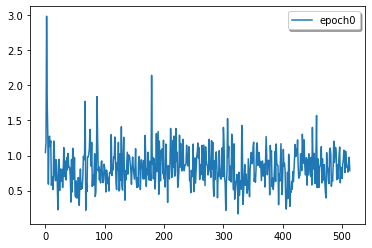

In [ ]:
# Set to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    # without considering batch size: Input shape : (None,207, 160, 1) , parameters: (3*3*1*16+16) = 160
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 16, # one input channel gray scale, 16 filters out
                            kernel_size = 3, stride = 1, padding = 1) #Out:(None,207, 160, 16)

    #Normalize each output to help w/ faster learning                       
    self.bn1 = nn.BatchNorm2d(16)
    self.pool1 = nn.MaxPool2d(2, 2) #Out: (None, 104, 80, 16)
    self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, 
                          kernel_size = 3, stride = 1, padding = 1) #Out: (None, 104, 80, 32), params: (3*3*16*32+32) = 4640                         
    self.bn2 = nn.BatchNorm2d(32) 
    self.pool2 = nn.MaxPool2d(2, 2) #Output shape = (None, 52, 40, 32)
    # Flatten
    self.fc1 = nn.Linear(32*51*40,120)
    self.fc2 = nn.Linear(120, 30)
    self.fc3 = nn.Linear(30, 3) # left with 3 for the three classes






  def forward(self, x):
    x = self.pool1(self.bn1(F.relu(self.conv1(x))))
    x = self.pool2(self.bn2(F.relu(self.conv2(x))))
    x = x.view(x.size(0),32*51*40)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x






# Create model object 
model = ConvNet().to(device)
for param in model.parameters():
  print(str(param.data.numpy().shape)+'\n')
  #print("weights fc1: ", model.fc1.weight)
  #print("weights fc3: ", model.fc3.weight)

# Loss function
criterion = nn.CrossEntropyLoss()

#Optimizer (can use SGD or ADAM)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)#, momentum = 0.9) #or ADAM/ momentum
acc = 0 # accuracy
#epoch = 0 # training episodes
n_total_steps = len(train_loader) 






def train_model(epochs):
  # set model in training mode (recommended)
  model.train()
  for epoch in range(epochs):
    losses = []
    running_loss = 0.0
    num_times = 0
    for i, (images, labels) in enumerate(train_loader, 0):
      images = images.float().to(device) # for GPU support
      label = labels.float().to(device)

      # sets gradients to 0 to prevent interference with previous epoch
      optimizer.zero_grad() 

      # Forward pass through NN
      outputs = model(images)
      loss = criterion(outputs, labels)

      # Backward pass, updating weights
      loss.backward()
      optimizer.step()
      #print(model.fc1.weight.detach().numpy())

      # Statistics 
      running_loss += loss.item()
      # Track every 100th loss:
      if i % 100 == 0:
        losses.append(loss.item())
        num_times = num_times + 1

      # print every 2000th batch
      if i % 1000 == 999:
        print('[%d %d] loss %.4f'% (epoch + 1, i + 1, running_loss/1000))
        running_loss = 0.0

    print("\nFinished training\n")
    # Calculate the accuracy and save the model state  
    accuracy()

    # Plot the loss
    plt.plot([i for i in range(num_times)],losses, label = 'epoch' + str(epoch))
    plt.legend(loc = 1, mode = 'expanded', shadow = True, ncol = 2)
  plt.show()






def accuracy():
  # set the model to evaluation mode
  model.eval()
  # Calculate performance
  correct = 0
  total = 0
  accuracy = 0
  for batches in test_loader:
    images, labels = batches
    prediction = model(images.float())
    _,prediction = torch.max(prediction.data, 1)# returns strongest label val and index
    total += labels.size(0)
    correct +=(prediction == labels).sum().item()

    accuracy = (correct/total) * 100
  print('Accuracy = '+str(accuracy))
  






#Turning off gradient tracking for this evaluation task since we are not training
#@torch.no_grad() 
def get_all_preds(model, loader):
  all_preds = torch.tensor([])
  with torch.no_grad():
    for batch in loader:
      images, labels = batch

      preds = model(images.float())
      # concatenates all predictions per batch into one list
      all_preds = torch.cat((all_preds, preds),dim = 0) 
  
  return all_preds






def get_num_correct(predictions, labels):
  return predictions.argmax(dim = 1).eq(labels).sum().item()










if __name__ == '__main__':
  train_model(1)













## Create Confusion Matrix

In [ ]:
# Calculate a Confusion Matrix of all the data
train_preds = get_all_preds(model, train_loader)
preds_correct = get_num_correct(train_preds, y_train_tensor)
print("total correct: ", preds_correct)
print("Accuracy_p: ", (preds_correct/len(training_data))*100)

total correct:  27692
Accuracy_p:  67.39516658959819


In [ ]:
# Stack predicted and target labels along second dimension
stacked = torch.stack(
    (y_train_tensor, train_preds.argmax(dim = 1)),
    dim = 1
)
stacked.shape

for item in stacked:
  print(item)


tensor([2, 2])
tensor([2, 2])
tensor([0, 2])
tensor([2, 2])
tensor([2, 2])
tensor([2, 2])
tensor([2, 2])
tensor([0, 2])
tensor([2, 2])
tensor([2, 2])
tensor([0, 2])
tensor([2, 2])
tensor([2, 2])
tensor([1, 2])
tensor([2, 2])
tensor([2, 2])
tensor([0, 2])
tensor([2, 2])
tensor([2, 2])
tensor([2, 2])
tensor([0, 2])
tensor([2, 2])
tensor([0, 2])
tensor([2, 2])
tensor([2, 2])
tensor([0, 2])
tensor([2, 2])
tensor([2, 2])
tensor([0, 2])
tensor([2, 2])
tensor([2, 2])
tensor([1, 2])
tensor([2, 2])
tensor([2, 2])
tensor([0, 2])
tensor([0, 2])
tensor([0, 2])
tensor([0, 2])
tensor([2, 2])
tensor([1, 2])
tensor([1, 2])
tensor([2, 2])
tensor([0, 2])
tensor([2, 2])
tensor([0, 2])
tensor([2, 2])
tensor([1, 2])
tensor([1, 2])
tensor([2, 2])
tensor([2, 2])
tensor([1, 2])
tensor([0, 2])
tensor([2, 2])
tensor([2, 2])
tensor([2, 2])
tensor([2, 2])
tensor([2, 2])
tensor([0, 2])
tensor([1, 2])
tensor([2, 2])
tensor([0, 2])
tensor([2, 2])
tensor([2, 2])
tensor([2, 2])
tensor([2, 2])
tensor([2, 2])
tensor([2,

KeyboardInterrupt: ignored

In [ ]:
# Create grid to fill in matrix with False positive, False Negative, True Positive, True Negative counts
cmtx = torch.zeros(3, 3, dtype = torch.int64)
cmtx

tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])

In [ ]:
for val in stacked:
  tar_lab, pred_lab = val.tolist()
  cmtx[tar_lab, pred_lab] = cmtx[tar_lab, pred_lab] + 1
cmtx

tensor([[  112,     9,  9244],
        [   43,    54,  4010],
        [   76,    15, 27526]])

In [ ]:
!pip install torchmetrics


     |████████████████████████████████| 282 kB 5.2 MB/s 


In [ ]:
import torch
# import our library
import torchmetrics
from torchmetrics import ConfusionMatrix
#target
y_train_tensor
# predictions
train_preds

confmat = ConfusionMatrix(num_classes=3)
f = confmat(train_preds, y_train_tensor)
# make heat map from this matrix

In [ ]:
f

tensor([[1.1200e+02, 9.0000e+00, 9.2440e+03],
        [4.3000e+01, 5.4000e+01, 4.0100e+03],
        [7.6000e+01, 1.5000e+01, 2.7526e+04]])

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
import numpy as np
import matplotlib.pyplot as plt

# Code from plotcm.py on deeplizard.com/learn/
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



Confusion matrix, without normalization
tensor([[1.1200e+02, 9.0000e+00, 9.2440e+03],
        [4.3000e+01, 5.4000e+01, 4.0100e+03],
        [7.6000e+01, 1.5000e+01, 2.7526e+04]])


ValueError: ignored

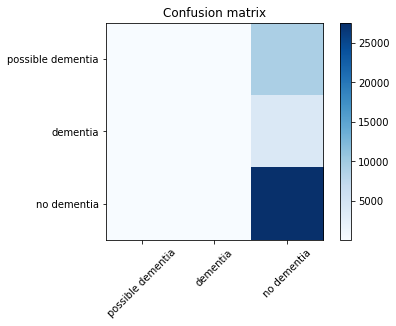

In [ ]:
plot_confusion_matrix(f, classes = ["possible dementia", 'dementia', 'no dementia'])

TypeError: ignored

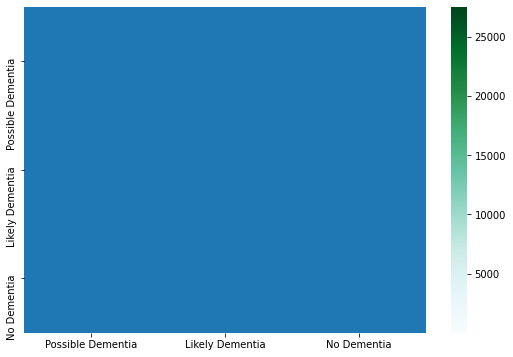

In [ ]:
#plot_confusion_matrix(confmat, ["Possible Dementia", "Likely Dementia", "No Dementia"])
import pandas as pd
import seaborn as sns
class_names = ["Possible Dementia", "Likely Dementia", "No Dementia"]
df_cm = pd.DataFrame(f, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

In [ ]:
confmat.dtype

torch.float32

# Get Data 

In [ ]:
#Get Data
# double split to get validation and test
ratio_val = 0.1
ratio_test = 0.1

# Get Data
x_data = np.load("/content/gdrive/MyDrive/Colab Notebooks/numpy_files/{}".format("placeholder larger data"))
y_data = np.load("/content/gdrive/MyDrive/Colab Notebooks/numpy_files/{}".format("placeholder larger labels"))

# Get Train and Test split
X_split, X_test, y_split, y_test = train_test_split(x_data, y_data, test_size = ratio_test, random_state = 6) 

# Adjust remaining ratio for even split
ratio_remaining = 1 - ratio_test #.11111
ratio_val_ad = ratio_val / ratio_remaining 

# Get Train and Val split
X_train, X_val, y_train, y_val = train_test_split(X_split, y_split, test_size = ratio_val_ad, random_state = 6)

# Visualize distributions of labels
plt.hist(y_train)
plt.hist(y_val)
plt.hist(y_test)
plt.show()


In [ ]:
# No need to normalize

# Zip image data and labels together
training_data = [(x, y) for x, y in zip(X_train, y_train)]
validation_data = [(x,y) for x, y in zip(X_val, y_val)]
test_data = [(x,y) for x, y in zip(X_test, y_test)]


# Variables for X - X_train, X_val, X_test
#Variables for y - y_train, y_val, y_test

train_loader = torch.utils.data.DataLoader(training_data, batch_size = batch_size, shuffle = True) 
validate_loader = torch.utils.data.DataLoader(validation_data, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = True)

#Labels 
classes = (0, 1, 2)